In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve, precision_score
from sklearn.ensemble import GradientBoostingClassifier

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sns.set()

In [2]:
from loader import *
from neural_network import *
from plot import *
from train import *
from loss import *

# LOAD FILES AND PREPARE TRAIN AND TEST SET

In [3]:
insee_dataset = pd.read_csv('../data/data_INSEE_clean.csv', sep=';', dtype = {'code': str})
secound_round_result = pd.read_csv("../data/clean_s_round_elect_results.csv", sep = ",") 
secound_round_result = secound_round_result.drop(columns=["Inscrits", "% Abs/Ins"])


In [4]:

dataset = insee_dataset.merge(secound_round_result, how='inner', left_on='code', right_on='Code Insee') \
                             .drop(columns=["Code Insee"])


In [5]:
# DIFFERENT SETS OF FEATURES 
sparse_features = ['density_pop', 'Indice_vieillissement', 'ratio_etude_sup','mean_familiy_size',\
                   'ratio_no_diploma', 'hlm', 'res_second', 'ta_homme', 'part_agri_y', 'part_cadre']

all_features = list(set(insee_dataset.columns) - set(["code", "commune", "pop", "type_agglo"]))

features_wo_equipmements = list(set(all_features)-set(['hypermarché', 'pôle emploi','banques', 'poste', 'epicerie', \
                'boulangerie', 'boucherie', 'maternelle', 'élémentaire', 'collège', 'urgences', \
                'lycee', 'dentiste', 'medecin','infirmier', 'creche', 'kine', 'pharmacie', 'epahd']))

In [11]:
# CHOOSE THE FEATURES YOU WANT TO KEEP
features_to_keep = sparse_features
nb_features = len(features_to_keep)

print("number of features", nb_features)

# CHOOSE DIFFERENT VARIABLES
batch_size = 36
min_habs = 1000
test_size = 0.5

number of features 10


In [12]:
x_train, x_test, y_train, y_test, train_loader, town_train_index, town_test_index = \
    load_data(dataset, features_to_keep, batch_size, min_habs, test_size, turn=2)


# SIMPLE LOGISTIC REGRESSION ON THE DISTRIBUTION RESULTS


In [125]:
log_reg = Log_reg_one_neuron(nb_features)
optims = torch.optim.Adam(log_reg.parameters())
loss = cross_entropy_loss_1Neuron

In [126]:
train_neurals_networks(n_epochs=100, train_loader=train_loader, \
                       list_of_loss_function=[loss], \
                       list_of_models=[log_reg],\
                       list_of_optim=[optims],\
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.690740784576961
----
epoch n° 10
  model n° 0 - loss : 0.6693684208524097
----
epoch n° 20
  model n° 0 - loss : 0.6693368077278137
----
epoch n° 30
  model n° 0 - loss : 0.6693691895558284
----
epoch n° 40
  model n° 0 - loss : 0.6693376226739569
----
epoch n° 50
  model n° 0 - loss : 0.6693802692077973
----
epoch n° 60
  model n° 0 - loss : 0.6693621957695092
----
epoch n° 70
  model n° 0 - loss : 0.6693752443397438
----
epoch n° 80
  model n° 0 - loss : 0.6693884659599472
----
epoch n° 90
  model n° 0 - loss : 0.6693775736368619
----


In [117]:
pred_list = pred_model(x_train, x_test, [log_reg], turn=2)

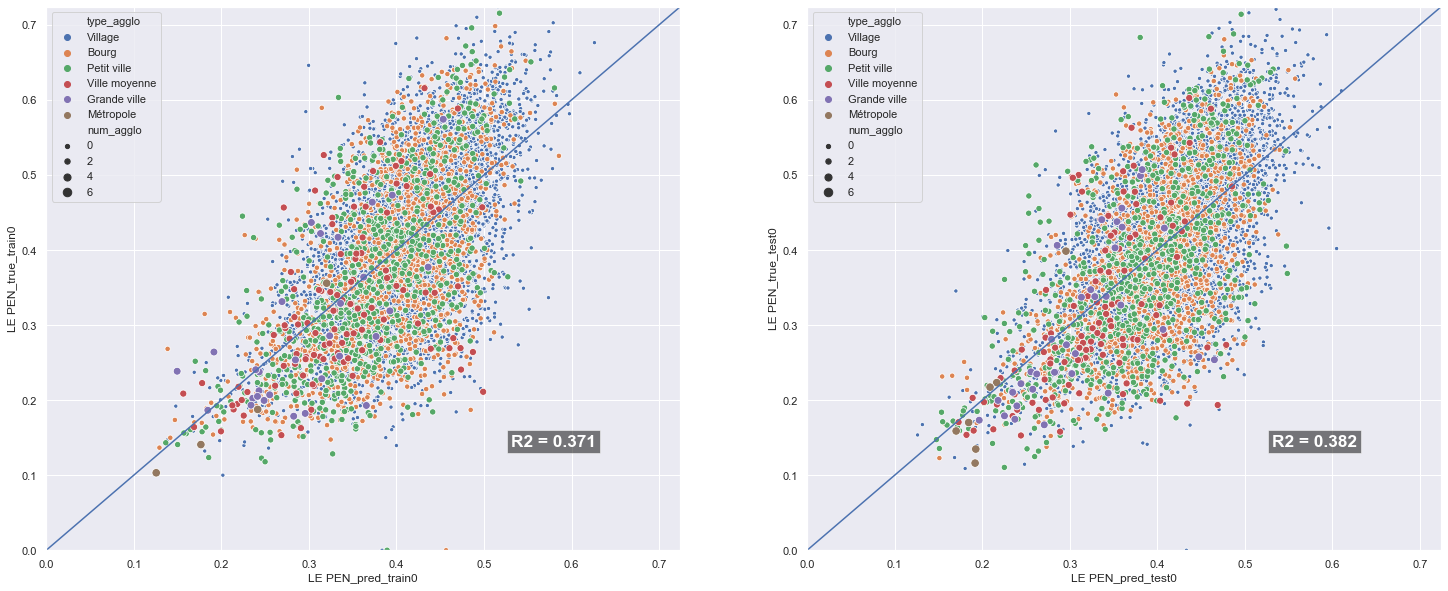

In [118]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)

In [119]:
features_importancy = pd.DataFrame(list(log_reg.parameters())[0].detach().numpy()[0], columns=["importancy"])

features_importancy["Features"] = sparse_features

features_importancy['abs_importancy'] = features_importancy['importancy'].apply(abs)
features_importancy = features_importancy.sort_values('abs_importancy', ascending=False)
features_importancy

,importancy,Features,abs_importancy
2,-0.252834,ratio_etude_sup,0.252834
3,0.112021,mean_familiy_size,0.112021
1,-0.093178,Indice_vieillissement,0.093178
8,-0.059029,part_agri_y,0.059029
4,0.054763,ratio_no_diploma,0.054763
5,-0.049716,hlm,0.049716
7,0.010328,ta_homme,0.010328
6,0.009620,res_second,0.009620
9,-0.008122,part_cadre,0.008122
0,-0.003003,density_pop,0.003003


In [106]:
df = pred_list[0][1]
df["Type_agglo"] = town_train_index["type_agglo"].values
df["True LE PEN"] = y_test.ravel()

In [107]:
df_pred_test

NameError: name 'df_pred_test' is not defined

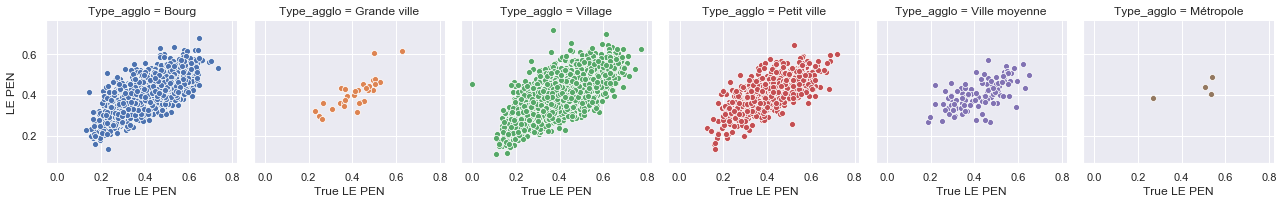

In [79]:
g = sns.FacetGrid(df, col="Type_agglo", hue ="Type_agglo")
g.map(sns.scatterplot, "True LE PEN", "LE PEN")

# NEURAL NETWORKS ON THE DISTRIBUTION RESULTS
Can we improve result by adding one layer ?

In [12]:
models = [Log_reg_one_neuron(nb_features), NN_2Layers_1Neuron(nb_features, 200)]
optims = [torch.optim.Adam(models[0].parameters()), torch.optim.Adam(models[1].parameters())]
loss = [cross_entropy_loss, cross_entropy_loss]

In [13]:
train_neurals_networks(n_epochs=50, train_loader=train_loader, \
                       list_of_loss_function=loss, \
                       list_of_models=models,\
                       list_of_optim=optims,\
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.6823270983166165
  model n° 1 - loss : 0.6559946399832529
----
epoch n° 10
  model n° 0 - loss : 0.6536349289947085
  model n° 1 - loss : 0.6506550756711809
----
epoch n° 20
  model n° 0 - loss : 0.6534605456723107
  model n° 1 - loss : 0.6488560977436247
----
epoch n° 30
  model n° 0 - loss : 0.6533754529461028
  model n° 1 - loss : 0.648337160311048
----
epoch n° 40
  model n° 0 - loss : 0.6533420705606067
  model n° 1 - loss : 0.6477675579843067
----


In [14]:
pred_list = pred_model(x_train, x_test, models, turn=2)

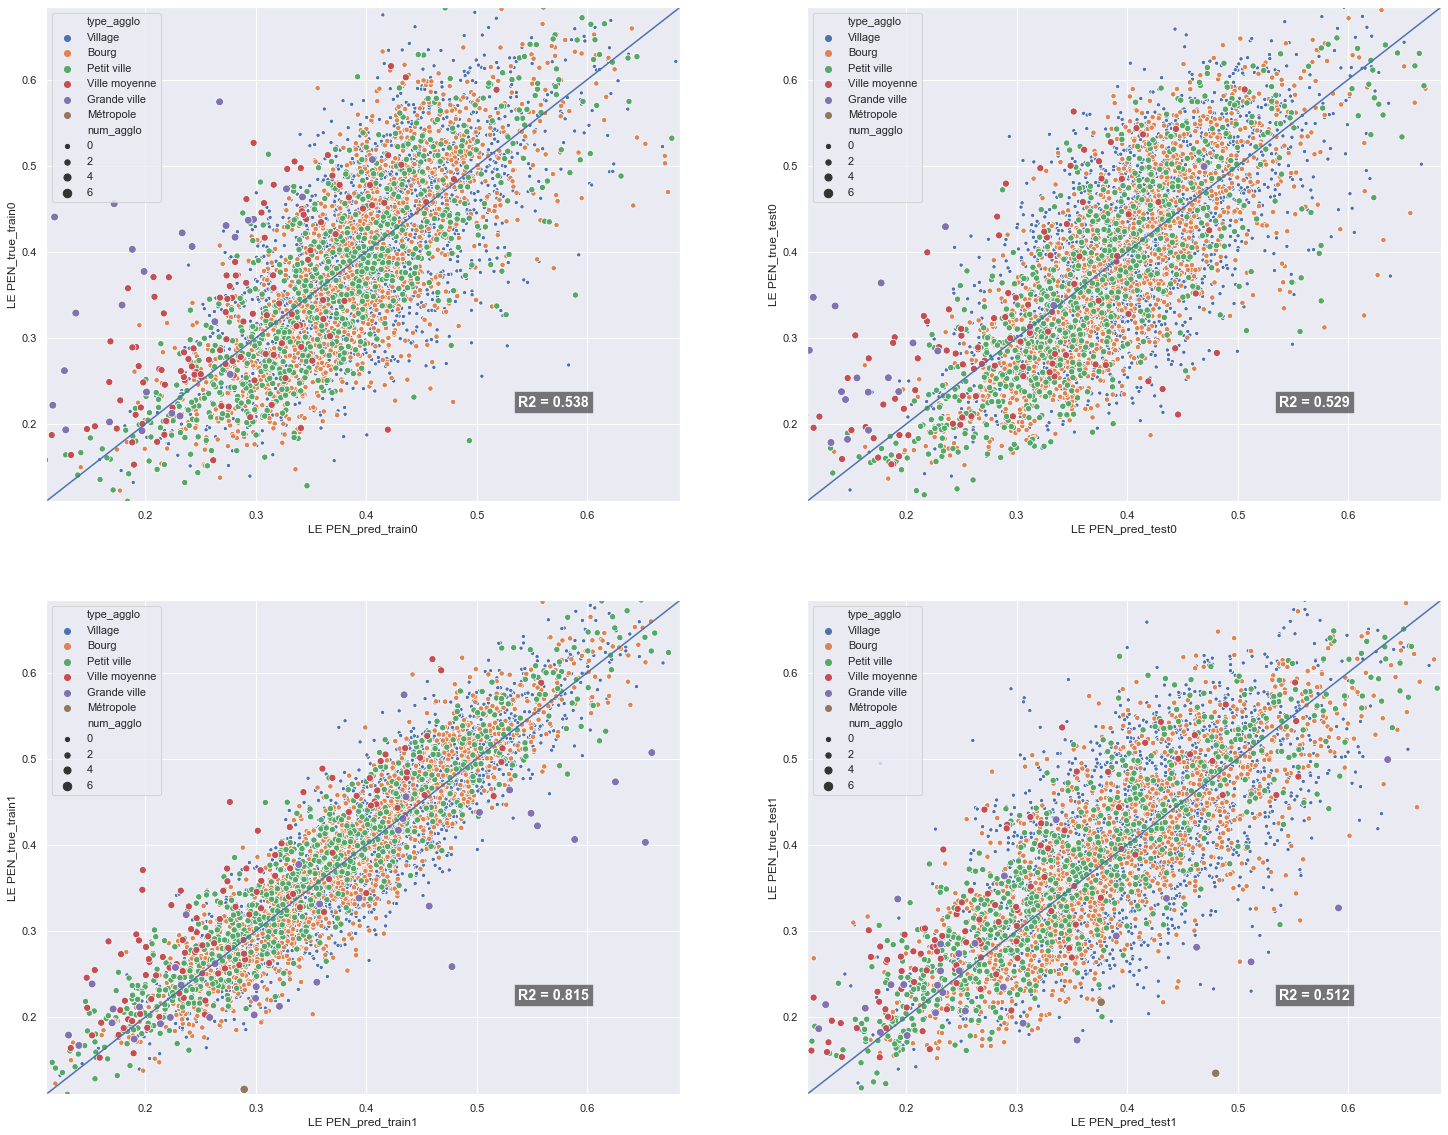

In [15]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)

# SIMPLE LOGISTIC REGRESSION CLASSIFIER WITH SCIKIT
Here we just take into account the winner to train a simple reg_log classifier.

In [14]:
y_train_winner = np.where(y_train > 0.5, 1, 0)
y_test_winner = np.where(y_test > 0.5, 1, 0)

### SIMPLE LOGISTIC REGRESSION CLASSIFIER
Here we just take into account the winner to train a simple reg_log classifier.

In [15]:
clf_lr = LogisticRegression(solver='liblinear')

param_grid_lr = {"C" : [0.01,0.05,0.1,1.0]}
gridsearch_lr = GridSearchCV(clf_lr,param_grid=param_grid_lr, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch_lr.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch_lr.cv_results_).T

,0,1,2,3
mean_fit_time,0.0158243,0.0170283,0.0174371,0.0158938
std_fit_time,0.00342679,0.00279426,0.00332323,0.000840885
mean_score_time,0.000619245,0.000736785,0.000558186,0.000842595
std_score_time,0.000427043,0.00040056,0.000571626,0.000379188
param_C,0.01,0.05,0.1,1
params,{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1.0}
split0_test_score,0.836645,0.836645,0.836645,0.836645
split1_test_score,0.827815,0.83223,0.834437,0.836645
split2_test_score,0.84106,0.838852,0.834437,0.838852
split3_test_score,0.829646,0.853982,0.858407,0.858407


In [16]:
clf_lr = LogisticRegression(solver='liblinear', C=0.1)
clf_lr.fit(x_train, y_train_winner.ravel())

y_pred = clf_lr.predict(x_test)

print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

Confusion matrix : 
  [[3621   94]
 [ 641  163]]
Accuracy :  0.8373533967691967


### SVM

In [19]:
clf_svc = SVC(gamma='auto')

param_grid_svc = {"C" : [0.01,0.05,0.1,1.0]}
gridsearch_svc = GridSearchCV(clf_svc,param_grid=param_grid_svc, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch_svc.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch_svc.cv_results_).T

,0,1,2,3
mean_fit_time,0.491472,0.496292,0.502818,0.540724
std_fit_time,0.0254694,0.0141681,0.00844365,0.00725064
mean_score_time,0.0374826,0.0340342,0.0346142,0.0342942
std_score_time,0.013855,0.00195051,0.00063443,0.000602952
param_C,0.01,0.05,0.1,1
params,{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1.0}
split0_test_score,0.825607,0.825607,0.825607,0.845475
split1_test_score,0.825607,0.825607,0.825607,0.843267
split2_test_score,0.825607,0.825607,0.825607,0.834437
split3_test_score,0.825221,0.825221,0.825221,0.845133


In [20]:
clf = SVC(C=1)
clf.fit(x_train, y_train_winner.ravel())

y_pred = clf.predict(x_test)

print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

Confusion matrix : 
  [[3681   34]
 [ 682  122]]
Accuracy :  0.8415578667846869


### Gradient Boosting Classifier

In [21]:
clf = GradientBoostingClassifier(random_state=0)

param_grid = {"n_estimators" : [100,500],
                "max_depth" : [2,3,4]}

gridsearch = GridSearchCV(clf,param_grid=param_grid, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch.fit(x_train, y_train_winner.ravel())
pd.DataFrame(gridsearch.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.418085,2.1209,0.639725,2.92223,0.849042,4.27193
std_fit_time,0.0296041,0.193942,0.0439466,0.0246415,0.0498637,0.0192579
mean_score_time,0.00187974,0.00607121,0.00249989,0.0076679,0.00291657,0.01005
std_score_time,0.000399213,0.00109172,0.000512184,0.000421627,0.000155891,0.000423742
param_max_depth,2,2,3,3,4,4
param_n_estimators,100,500,100,500,100,500
params,"{'max_depth': 2, 'n_estimators': 100}","{'max_depth': 2, 'n_estimators': 500}","{'max_depth': 3, 'n_estimators': 100}","{'max_depth': 3, 'n_estimators': 500}","{'max_depth': 4, 'n_estimators': 100}","{'max_depth': 4, 'n_estimators': 500}"
split0_test_score,0.843267,0.843267,0.854305,0.847682,0.834437,0.834437
split1_test_score,0.854305,0.860927,0.860927,0.871965,0.856512,0.85872
split2_test_score,0.843267,0.847682,0.843267,0.863135,0.84106,0.85872


In [22]:
gridsearch = GradientBoostingClassifier(random_state=0, max_depth=2, n_estimators=200)

gridsearch.fit(x_train,y_train_winner)

y_pred = gridsearch.predict(x_test)

print('Confusion matrix : \n ',confusion_matrix(y_test_winner,y_pred))
print('Accuracy : ', accurracy(y_test_winner,y_pred))

c:\users\anton\miniconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix : 
  [[3614  101]
 [ 574  230]]
Accuracy :  0.8506306705023235


### STUDY WHICH FEATURES ARE IMPORTANT FOR THE CLASSIFIER 

In [57]:
features_importancy = pd.DataFrame(features_to_keep, columns=['features'])
features_importancy['importancy'] = clf_lr.coef_.T

# We sort by importancy 
features_importancy['abs_importancy'] = features_importancy['importancy'].apply(abs)
features_importancy = features_importancy.sort_values('abs_importancy', ascending=False)

# We keep only the 5 most important features 
features_importancy = features_importancy.iloc[:10,:]
features_importancy = features_importancy.sort_values('importancy', ascending=True)


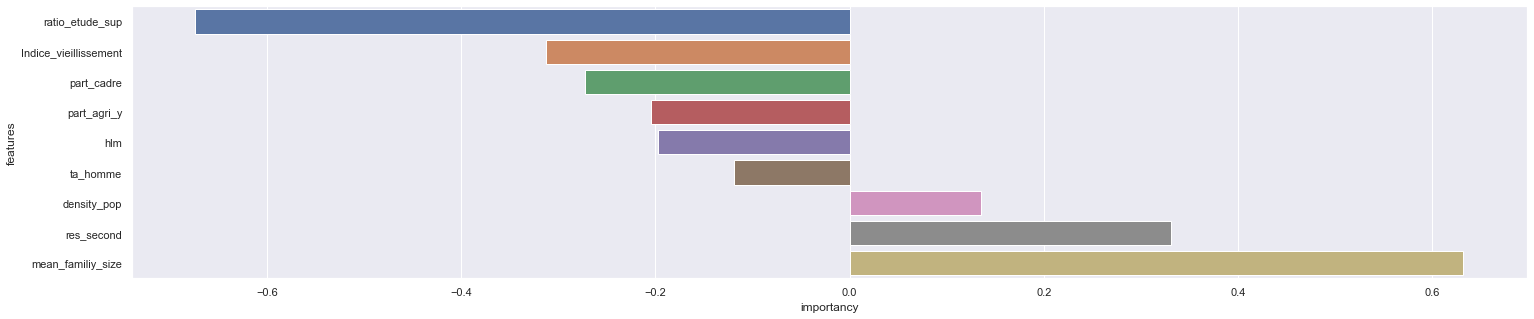

In [58]:
f, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.barplot(x="importancy", y="features", data=features_importancy)


In [59]:
y_result = gridsearch_lr.predict_proba(x_test)[:,1]
y_train_result = gridsearch_lr.predict_proba(x_train)[:,1]

In [42]:
fpr, tpr, _ = roc_curve(y_test_winner, y_result)
roc_auc = roc_auc_score(y_test_winner, y_result)

#On train set
fpr_t, tpr_t, _ = roc_curve(y_train_winner, y_train_result)
roc_auc_t = roc_auc_score(y_train_winner, y_train_result)

### HOW GOOD IS THIS SIMPLE CLASSIFIER ? 

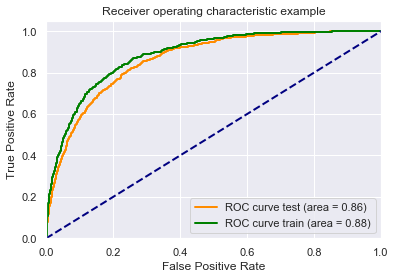

In [43]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# TRY SOME DIFFERENT ALGO ON THE SAME DATESET
Objectif : improve R2 score 

### RANDOM FOREST REGRESSION

In [28]:
regr = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=2000)

In [29]:
regr.fit(x_train, y_train)

/Users/dldk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [30]:
y_pred_test = regr.predict(x_test)

In [31]:
y_pred_train = regr.predict(x_train)

In [32]:
regr.score(x_test, y_test)

0.5845554731609339

In [33]:
regr.score(x_train, y_train)

0.8403071941243373

In [34]:
pred_list = [(pd.DataFrame(y_pred_train, columns=["LE PEN"]), pd.DataFrame(y_pred_test, columns=["LE PEN"]))]

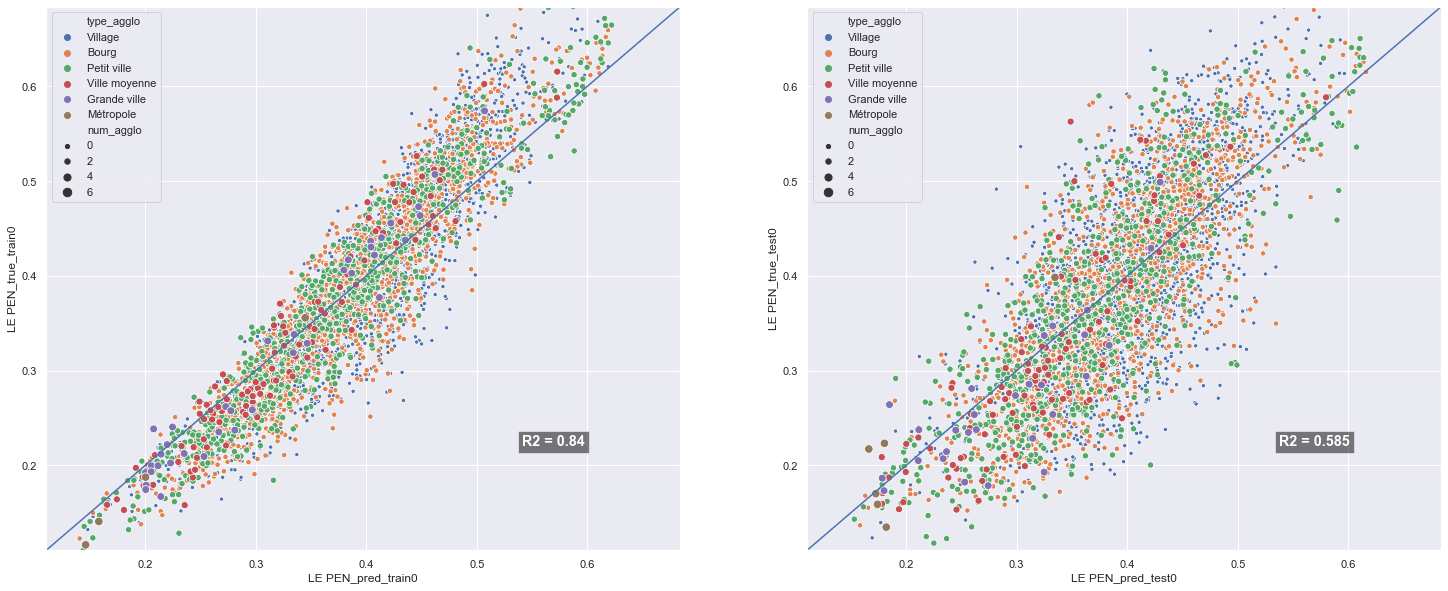

In [35]:
regression_plot(y_train, y_test, pred_list, "LE PEN", town_train_index, town_test_index, turn=2)